# 05 — Two-Stage Factor Risk Parity — ETF Replication (FRP-EMP)

Implements the **two-stage Factor Risk Parity** strategy described in `docs/vibe/etf_am_plan.md §5`:

| Stage | Problem | Output |
|-------|---------|--------|
| **Stage 1** | Factor Risk Parity (log-barrier) on JKP 13 themes | `phi_star (T_reb, 13)` |
| **Stage 2** | Constrained QP — ETF replication of `phi_star` | `weights_frp (T_reb, N)` |

**Benchmarks**: Equal-Weight (EW-EMP), Minimum-Variance (MV-EMP)

**Performance**: Sharpe, MDD, Calmar, Turnover, Herfindahl

Reference: `notebooks/04_ETFAM_FACTORREG.ipynb`, `docs/vibe/etf_am_plan.md`

---

## 1. Imports & Constants

In [21]:
from pathlib import Path

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import cvxpy as cp
from scipy.optimize import minimize

from utils.chkxp_ingest import open_etf_daily

warnings.filterwarnings("ignore", category=FutureWarning)

# ── paths ────────────────────────────────────────────────────────────────────
CHKXP_RAW_DIR = Path("../data/raw/chkxp")
JKP_RAW_DIR   = Path("../data/raw/jkp")
CHKXP_DB_DIR  = Path("../data/db/chkxp/etf_daily")

# ── analysis parameters ──────────────────────────────────────────────────────
START_DATE = "2020-01-01"
END_DATE   = "2023-12-31"
WINDOW     = 120        # rolling window for both regression & covariance estimation
W_MAX      = 0.10       # max ETF weight in Stage 2 QP
MIN_OBS    = 120        # minimum valid return observations for ETF inclusion

print(f"START_DATE : {START_DATE}")
print(f"END_DATE   : {END_DATE}")
print(f"WINDOW     : {WINDOW}")
print(f"W_MAX      : {W_MAX}")

START_DATE : 2020-01-01
END_DATE   : 2023-12-31
WINDOW     : 120
W_MAX      : 0.1


---

## 2. Data Reload

Reproduces the data loading and alignment from `04_ETFAM_FACTORREG.ipynb`.
This notebook is self-contained — all inputs are rebuilt from raw files.

In [22]:
# ── ETF prices → daily returns ────────────────────────────────────────────────
ds_etf = open_etf_daily(
    [
        CHKXP_RAW_DIR / "chkxp_etf(ACE)(KIWOOM)(PLUS)_from(20201010)_to(20260219).csv",
        CHKXP_RAW_DIR / "chkxp_etf(KODEX)_from(20201010)_to(20260219).csv",
        CHKXP_RAW_DIR / "chkxp_etf(RISE)(SOL)_from(20201010)_to(20260219).csv",
        CHKXP_RAW_DIR / "chkxp_etf(TIGER)_from(20201010)_to(20260219).csv",
    ],
    output_dir=CHKXP_DB_DIR,
)
df_etf = ds_etf.load()
df_etf = df_etf[
    (df_etf["date"] >= pd.Timestamp(START_DATE)) &
    (df_etf["date"] <= pd.Timestamp(END_DATE))
].copy()
df_etf["entity_code"] = df_etf["entity_code"].str.replace(r"\*\d+$", "", regex=True)
price_wide = (
    df_etf
    .pivot_table(index="date", columns="entity_code", values="현재가", aggfunc="last")
    .sort_index()
)
R_etf = price_wide.pct_change().iloc[1:]

# ── JKP 13-theme factor returns ───────────────────────────────────────────────
df_jkp_themes = pd.read_csv(
    JKP_RAW_DIR / "[kor]_[all_themes]_[daily]_[vw_cap].csv",
    parse_dates=["date"],
)
df_jkp_themes = df_jkp_themes[
    (df_jkp_themes["date"] >= pd.Timestamp(START_DATE)) &
    (df_jkp_themes["date"] <= pd.Timestamp(END_DATE))
]
R_factor = (
    df_jkp_themes
    .pivot_table(index="date", columns="name", values="ret", aggfunc="last")
    .sort_index()
)
R_factor.columns.name = None

# ── JKP market return ─────────────────────────────────────────────────────────
df_jkp_mkt = pd.read_csv(
    JKP_RAW_DIR / "[kor]_[mkt]_[daily]_[vw_cap].csv",
    parse_dates=["date"],
)
df_jkp_mkt = df_jkp_mkt[
    (df_jkp_mkt["date"] >= pd.Timestamp(START_DATE)) &
    (df_jkp_mkt["date"] <= pd.Timestamp(END_DATE))
]
R_mkt = (
    df_jkp_mkt
    .pivot_table(index="date", columns="name", values="ret", aggfunc="last")
    .sort_index()
)
R_mkt.columns.name = None

print(f"R_etf    : {R_etf.shape}    {R_etf.index[0].date()} → {R_etf.index[-1].date()}")
print(f"R_factor : {R_factor.shape}  {R_factor.index[0].date()} → {R_factor.index[-1].date()}")
print(f"R_mkt    : {R_mkt.shape}    {R_mkt.index[0].date()} → {R_mkt.index[-1].date()}")

R_etf    : (986, 194)    2020-01-03 → 2023-12-28
R_factor : (988, 13)  2020-01-02 → 2023-12-28
R_mkt    : (987, 1)    2020-01-02 → 2023-12-28


In [23]:
# ── inner-join alignment ──────────────────────────────────────────────────────
common_dates = R_etf.index.intersection(R_factor.index).intersection(R_mkt.index)
R_etf    = R_etf.loc[common_dates]
R_factor = R_factor.loc[common_dates]
R_mkt    = R_mkt.loc[common_dates]

# R_factor_full = [mkt | 13 JKP themes] — used as regressors in rolling OLS
R_factor_full = pd.concat([R_mkt, R_factor], axis=1)

dates   = R_etf.index                    # DatetimeIndex, length T
tickers = R_etf.columns.tolist()         # list[str] of N ETF codes
T, N    = R_etf.shape
M_full  = R_factor_full.shape[1]         # 14 = 1 mkt + 13 JKP
M       = R_factor.shape[1]              # 13 JKP themes only
factor_names = R_factor.columns.tolist() # 13 theme names

print(f"Aligned: T={T}, N={N}, M_full={M_full}, M_jkp={M}")
print(f"Date range: {dates[0].date()} → {dates[-1].date()}")
print(f"JKP themes: {factor_names}")

Aligned: T=986, N=194, M_full=14, M_jkp=13
Date range: 2020-01-03 → 2023-12-28
JKP themes: ['accruals', 'debt_issuance', 'investment', 'low_leverage', 'low_risk', 'momentum', 'profit_growth', 'profitability', 'quality', 'seasonality', 'short_term_reversal', 'size', 'value']


---

## 3. Rolling OLS (w=120) — Rebuild BETAS_w120

Regressors: `R_factor_full` (mkt + 13 JKP themes, M=14).  
For the FRP stage we will slice `BETAS_w120[:, :, 1:]` to extract only the 13 JKP theme betas.

In [24]:
R_etf_arr    = R_etf.values.astype(np.float64)         # (T, N)
R_factor_arr = R_factor_full.values.astype(np.float64) # (T, M_full=14)

BETAS_w120 = np.full((T, N, M_full), np.nan)
ALPHA_w120 = np.full((T, N), np.nan)
RESID_w120 = np.full((T, N), np.nan)

ones = np.ones((T, 1))
X_full = np.hstack([ones, R_factor_arr])  # (T, 1+M_full) — intercept + factors

for t in range(WINDOW, T):
    X_win = X_full[t - WINDOW : t]        # (WINDOW, 1+M_full)
    Y_win = R_etf_arr[t - WINDOW : t]     # (WINDOW, N)

    # mask ETFs with at least WINDOW non-NaN obs in this window
    valid = (~np.isnan(Y_win)).sum(axis=0) >= WINDOW
    if not valid.any():
        continue

    Y_sub = Y_win[:, valid]                # (WINDOW, n_valid)
    try:
        coeffs, _, _, _ = np.linalg.lstsq(X_win, Y_sub, rcond=None)  # (1+M_full, n_valid)
    except np.linalg.LinAlgError:
        continue

    ALPHA_w120[t, valid] = coeffs[0]
    BETAS_w120[t, valid, :] = coeffs[1:].T   # (n_valid, M_full)
    resid = Y_sub - X_win @ coeffs
    RESID_w120[t, valid] = resid[-1]

print(f"BETAS_w120 : {BETAS_w120.shape}  (T, N, M_full=14)")
print(f"ALPHA_w120 : {ALPHA_w120.shape}")
print(f"RESID_w120 : {RESID_w120.shape}")

# ── JKP-only betas: drop mkt column (index 0) ────────────────────────────────
# BETAS_jkp[t, i, j] = beta of ETF i on JKP theme j at date t
BETAS_jkp = BETAS_w120[:, :, 1:]   # (T, N, M=13)
print(f"BETAS_jkp  : {BETAS_jkp.shape}  (T, N, M_jkp=13)")

BETAS_w120 : (986, 194, 14)  (T, N, M_full=14)
ALPHA_w120 : (986, 194)
RESID_w120 : (986, 194)
BETAS_jkp  : (986, 194, 13)  (T, N, M_jkp=13)


---

## 4. Stage 1 — Factor Risk Parity (Log-Barrier)

**Formulation** (Maillard, Roncalli & Teïletche 2010 — log-barrier variant):

$$\phi^* = \arg\min_{\phi} \; \phi^\top \Sigma_f \phi - \frac{1}{M} \sum_{j=1}^M \ln \phi_j$$
$$\text{s.t.} \quad \mathbf{1}^\top \phi = 1, \quad \phi > 0$$

At optimum, each factor's **marginal risk contribution** (MRC) equals $1/M$ of total portfolio risk,
ensuring no single factor theme dominates the aggregate risk budget.

In [25]:
def factor_risk_parity(Sigma_f: np.ndarray) -> np.ndarray:
    """
    Solve Factor Risk Parity via log-barrier (convex SLSQP).
    Returns phi* (M,) — equal-risk-contribution weights over factor themes.

    Objective: min_{phi} phi.T @ Sigma_f @ phi  -  (1/M) * sum(ln(phi))
    s.t.  sum(phi) = 1,  phi > 0
    """
    M = Sigma_f.shape[0]
    phi0 = np.ones(M) / M

    def objective(phi):
        return phi @ Sigma_f @ phi - np.sum(np.log(phi)) / M

    def grad(phi):
        return 2.0 * Sigma_f @ phi - 1.0 / (M * phi)

    result = minimize(
        objective,
        phi0,
        jac=grad,
        method="SLSQP",
        bounds=[(1e-8, None)] * M,
        constraints={"type": "eq", "fun": lambda phi: phi.sum() - 1.0},
        options={"ftol": 1e-12, "maxiter": 2000},
    )
    if not result.success:
        # fall back to equal weight rather than raise
        return phi0
    phi = np.maximum(result.x, 0.0)
    phi /= phi.sum()
    return phi


def risk_contributions(phi: np.ndarray, Sigma_f: np.ndarray) -> np.ndarray:
    """Marginal Risk Contribution (MRC) as fraction of total portfolio risk."""
    port_var = phi @ Sigma_f @ phi
    mrc = phi * (Sigma_f @ phi) / port_var
    return mrc


# ── quick smoke test ──────────────────────────────────────────────────────────
_Sigma_test = R_factor.iloc[:WINDOW].cov().values
_phi_test   = factor_risk_parity(_Sigma_test)
_rc_test    = risk_contributions(_phi_test, _Sigma_test)

print("Stage 1 smoke test — equal risk contributions?")
print(f"  phi_test  : {np.round(_phi_test, 4)}")
print(f"  RC (frac) : {np.round(_rc_test, 4)}")
print(f"  RC range  : [{_rc_test.min():.4f}, {_rc_test.max():.4f}]  (ideal: all 1/M = {1/M:.4f})")

Stage 1 smoke test — equal risk contributions?
  phi_test  : [0.0769 0.0769 0.0769 0.0769 0.0769 0.0769 0.0769 0.0769 0.0769 0.0769
 0.0769 0.0769 0.0769]
  RC (frac) : [ 0.0792  0.0135  0.011   0.0383  0.2351  0.1508  0.0642  0.1558  0.1602
  0.0245  0.1431 -0.0603 -0.0154]
  RC range  : [-0.0603, 0.2351]  (ideal: all 1/M = 0.0769)


---

## 5. Stage 2 — ETF Replication QP (CLARABEL)

**Formulation**: Given the target factor allocation $\phi^*$ from Stage 1 and the ETF beta
matrix $B_t \in \mathbb{R}^{N \times M}$, find ETF weights $w^* \in \mathbb{R}^N$ minimising
the **factor tracking error**:

$$w^* = \arg\min_{w} \; (B_t^\top w - \phi^*)^\top \Sigma_f (B_t^\top w - \phi^*)$$
$$\text{s.t.} \quad \mathbf{1}^\top w = 1, \quad 0 \le w_i \le w_{\max}$$

This is a **constrained QP** solved with CVXPY's CLARABEL solver
(open-source, no licence required, conic-form interior-point).

In [26]:
def etf_replication(
    B_t: np.ndarray,
    phi_star: np.ndarray,
    Sigma_f: np.ndarray,
    w_max: float = W_MAX,
    valid_mask: np.ndarray = None,
) -> np.ndarray:
    """
    Stage 2: constrained QP — minimise factor tracking error to phi_star.

    Parameters
    ----------
    B_t        : (N, M) ETF beta matrix at rebalancing date t (NaN replaced with 0)
    phi_star   : (M,)   target factor allocation from Stage 1
    Sigma_f    : (M, M) factor covariance matrix
    w_max      : scalar maximum per-ETF weight
    valid_mask : (N,) bool — True for ETFs with sufficient history

    Returns
    -------
    w_full : (N,) portfolio weights, zero for excluded ETFs
    """
    N = B_t.shape[0]
    if valid_mask is None:
        valid_mask = np.ones(N, dtype=bool)

    idx   = np.where(valid_mask)[0]
    B_sub = B_t[idx, :]                  # (n_valid, M)
    n     = len(idx)

    if n == 0:
        return np.ones(N) / N            # degenerate fallback

    w = cp.Variable(n, nonneg=True)
    factor_exposure = B_sub.T @ w        # (M,)
    tracking_error  = factor_exposure - phi_star
    # psd_wrap tells CVXPY to trust Sigma_f is PSD, bypassing the ARPACK check
    objective       = cp.Minimize(cp.quad_form(tracking_error, cp.psd_wrap(Sigma_f)))

    constraints = [
        cp.sum(w) == 1.0,
        w <= w_max,
    ]

    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.CLARABEL, warm_start=True)

    if prob.status not in ("optimal", "optimal_inaccurate") or w.value is None:
        # fallback: equal weight across valid ETFs
        w_full = np.zeros(N)
        w_full[idx] = 1.0 / n
        return w_full

    w_full        = np.zeros(N)
    w_full[idx]   = np.maximum(w.value, 0.0)
    w_full       /= w_full.sum()         # renormalise for numerical safety
    return w_full


# ── smoke test with random feasible betas ─────────────────────────────────────
rng      = np.random.default_rng(42)
_B_test  = rng.standard_normal((10, M))   # 10 ETFs, 13 factors
_w_test  = etf_replication(_B_test, _phi_test, _Sigma_test)
print(f"Stage 2 smoke test — sum(w)={_w_test.sum():.6f}, max(w)={_w_test.max():.4f}")

Stage 2 smoke test — sum(w)=1.000000, max(w)=0.1000


---

## 6. Monthly Rebalancing Loop

Rebalancing frequency: **last business day of each month** (`BusinessMonthEnd`).
A rebalancing date is included only if at least `WINDOW` trading days of history are available.

In [27]:
# ── rebalancing date grid ─────────────────────────────────────────────────────
# Use BusinessMonthEnd offset; filter to dates with WINDOW days of history
_reb_raw = pd.date_range(dates[0], dates[-1], freq=pd.offsets.BusinessMonthEnd())
# map each calendar rebalancing date to the nearest available date in our index
reb_dates = pd.DatetimeIndex(
    [dates[dates.get_indexer([d], method="ffill")[0]] for d in _reb_raw
     if dates.get_indexer([d], method="ffill")[0] >= WINDOW]
).unique()

print(f"Rebalancing dates: {len(reb_dates)}  ({reb_dates[0].date()} → {reb_dates[-1].date()})")

Rebalancing dates: 42  (2020-06-30 → 2023-11-30)


In [28]:
phi_star_ts = pd.DataFrame(index=reb_dates, columns=factor_names, dtype=float)
weights_frp = pd.DataFrame(index=reb_dates, columns=tickers, dtype=float)
repl_error  = pd.DataFrame(index=reb_dates, columns=factor_names, dtype=float)
rc_ts       = pd.DataFrame(index=reb_dates, columns=factor_names, dtype=float)

R_factor_arr_jkp = R_factor.values  # (T, M=13)

n_failed = 0

for reb_date in reb_dates:
    t = dates.get_indexer([reb_date], method="ffill")[0]
    if t < WINDOW:
        continue

    # ── Stage 1: Factor Risk Parity ───────────────────────────────────────────
    window_slice = R_factor_arr_jkp[t - WINDOW : t]    # (WINDOW, M)
    Sigma_f = np.cov(window_slice.T)                    # (M, M)

    phi = factor_risk_parity(Sigma_f)
    phi_star_ts.loc[reb_date] = phi
    rc_ts.loc[reb_date] = risk_contributions(phi, Sigma_f)

    # ── Stage 2: ETF Replication QP ──────────────────────────────────────────
    B_t_full = BETAS_jkp[t, :, :]                       # (N, M=13)

    # valid ETFs: have at least WINDOW non-NaN obs before this rebalancing date
    valid_obs  = (~np.isnan(BETAS_jkp[:t, :, 0])).sum(axis=0)  # (N,)
    valid_mask = valid_obs >= WINDOW

    # also exclude ETFs where current beta is still NaN
    valid_mask &= ~np.isnan(B_t_full).any(axis=1)

    B_t_clean = np.nan_to_num(B_t_full, nan=0.0)        # safe for QP

    try:
        w = etf_replication(B_t_clean, phi, Sigma_f, valid_mask=valid_mask)
    except Exception:
        n_failed += 1
        w = np.where(valid_mask, 1.0 / valid_mask.sum(), 0.0)

    weights_frp.loc[reb_date] = w
    repl_error.loc[reb_date]  = B_t_clean.T @ w - phi

print(f"Rebalancing complete. Failures (fell back to EW): {n_failed}")
print(f"Valid weights: {weights_frp.notna().all(axis=1).sum()} / {len(reb_dates)} dates")
print(f"\nPhi_star sample (last rebalancing):")
print(phi_star_ts.iloc[-1].to_string())

Rebalancing complete. Failures (fell back to EW): 0
Valid weights: 42 / 42 dates

Phi_star sample (last rebalancing):
accruals               0.076923
debt_issuance          0.076922
investment             0.076920
low_leverage           0.076926
low_risk               0.076919
momentum               0.076928
profit_growth          0.076926
profitability          0.076923
quality                0.076924
seasonality            0.076925
short_term_reversal    0.076926
size                   0.076921
value                  0.076918


---

## 7. Benchmark Portfolios

### 7a. Equal-Weight (EW-EMP)

At each rebalancing date, allocate $1/n$ to each ETF with at least `WINDOW` observed returns.

In [29]:
weights_ew = pd.DataFrame(index=reb_dates, columns=tickers, dtype=float)

for reb_date in reb_dates:
    t = dates.get_indexer([reb_date], method="ffill")[0]
    if t < WINDOW:
        continue
    valid_obs  = (~np.isnan(R_etf.values[:t])).sum(axis=0)   # (N,)
    valid_mask = valid_obs >= WINDOW
    n_valid    = valid_mask.sum()
    w = np.where(valid_mask, 1.0 / n_valid, 0.0)
    weights_ew.loc[reb_date] = w

print(f"EW: avg valid ETFs = {(weights_ew > 0).sum(axis=1).mean():.0f}")

EW: avg valid ETFs = 138


### 7b. Minimum-Variance (MV-EMP)

Minimises portfolio variance using rolling 120-day ETF return covariance:

$$w^* = \arg\min_w \; w^\top \hat{\Sigma}_{\text{ETF}} \, w \quad \text{s.t.} \quad \mathbf{1}^\top w = 1, \; 0 \le w_i \le w_{\max}$$

In [30]:
weights_mv = pd.DataFrame(index=reb_dates, columns=tickers, dtype=float)

for reb_date in reb_dates:
    t = dates.get_indexer([reb_date], method="ffill")[0]
    if t < WINDOW:
        continue

    window_slice = R_etf.values[t - WINDOW : t]        # (WINDOW, N)

    # valid ETFs: no NaN in the full window
    valid_mask = (~np.isnan(window_slice)).all(axis=0)  # (N,)
    idx = np.where(valid_mask)[0]
    n   = len(idx)

    if n < 2:
        weights_mv.loc[reb_date] = weights_ew.loc[reb_date]
        continue

    R_sub   = window_slice[:, idx]                      # (WINDOW, n)
    Sigma_e = np.cov(R_sub.T)                           # (n, n)

    # add small ridge to ensure PSD
    Sigma_e += 1e-8 * np.eye(n)

    w_var = cp.Variable(n, nonneg=True)
    prob  = cp.Problem(
        cp.Minimize(cp.quad_form(w_var, cp.psd_wrap(Sigma_e))),
        [cp.sum(w_var) == 1.0, w_var <= W_MAX],
    )
    prob.solve(solver=cp.CLARABEL, warm_start=True)

    if prob.status not in ("optimal", "optimal_inaccurate") or w_var.value is None:
        weights_mv.loc[reb_date] = weights_ew.loc[reb_date]
        continue

    w_full       = np.zeros(N)
    w_full[idx]  = np.maximum(w_var.value, 0.0)
    w_full      /= w_full.sum()
    weights_mv.loc[reb_date] = w_full

print(f"MV: avg valid ETFs = {(weights_mv > 1e-6).sum(axis=1).mean():.0f}")

MV: avg valid ETFs = 138


---

## 8. Backtest Engine

**Buy-and-hold** between rebalancing dates: weights at date $t_{\text{reb},k}$ are held
until (and including) date $t_{\text{reb},k+1}$, then replaced.  
All returns within the holding period are computed using the fixed weights — no intra-period drift adjustment.

In [31]:
def portfolio_returns(
    weights_df: pd.DataFrame,
    R_etf_df: pd.DataFrame,
) -> pd.Series:
    """
    Compute daily portfolio return series given monthly rebalancing weights.
    Weights at rebalancing date t_reb apply to all days (t_reb, t_reb+1].
    """
    port_ret = pd.Series(np.nan, index=R_etf_df.index)
    reb_list = weights_df.dropna(how="all").index.tolist()

    for i, reb_date in enumerate(reb_list):
        end_date = reb_list[i + 1] if i + 1 < len(reb_list) else R_etf_df.index[-1]
        mask = (R_etf_df.index > reb_date) & (R_etf_df.index <= end_date)
        w    = weights_df.loc[reb_date].fillna(0.0).values
        port_ret.loc[mask] = R_etf_df.loc[mask].fillna(0.0).values @ w

    return port_ret.dropna()


ret_frp = portfolio_returns(weights_frp, R_etf)
ret_ew  = portfolio_returns(weights_ew,  R_etf)
ret_mv  = portfolio_returns(weights_mv,  R_etf)

print(f"FRP-EMP : {len(ret_frp)} days, {ret_frp.index[0].date()} → {ret_frp.index[-1].date()}")
print(f"EW-EMP  : {len(ret_ew)}  days")
print(f"MV-EMP  : {len(ret_mv)}  days")

FRP-EMP : 864 days, 2020-07-01 → 2023-12-28
EW-EMP  : 864  days
MV-EMP  : 864  days


---

## 9. Performance Metrics

| Metric | Formula |
|--------|---------|
| **Sharpe** | $(r_{ann} - r_f) / \sigma_{ann}$ |
| **MDD** | $\min_t (C_t / \max_{s \le t} C_s - 1)$ |
| **Calmar** | $r_{ann} / |\text{MDD}|$ |
| **Turnover** | $\frac{1}{T_{reb}} \sum_t \|w_t - w_{t-1}\|_1$ |
| **Herfindahl** | $\mathbb{E}_t[\sum_i w_{i,t}^2]$ (concentration) |

In [32]:
def max_drawdown(ret: pd.Series) -> float:
    cum = (1.0 + ret).cumprod()
    return (cum / cum.cummax() - 1.0).min()


def turnover(weights_df: pd.DataFrame) -> float:
    """Average L1 turnover across rebalancing events."""
    w = weights_df.fillna(0.0).values.astype(float)
    if len(w) < 2:
        return np.nan
    return np.mean(np.abs(np.diff(w, axis=0)).sum(axis=1))


def herfindahl(weights_df: pd.DataFrame) -> float:
    """Average Herfindahl-Hirschman index (ETF weight concentration)."""
    w = weights_df.fillna(0.0).values.astype(float)
    return np.mean((w ** 2).sum(axis=1))


def performance_table(
    ret: pd.Series,
    weights_df: pd.DataFrame,
    label: str,
    rf: float = 0.0,
    ann_factor: int = 252,
) -> dict:
    ann_ret = (1.0 + ret).prod() ** (ann_factor / len(ret)) - 1.0
    ann_vol = ret.std() * np.sqrt(ann_factor)
    sharpe  = (ann_ret - rf) / ann_vol if ann_vol > 0 else np.nan
    mdd     = max_drawdown(ret)
    calmar  = ann_ret / abs(mdd) if mdd != 0 else np.nan
    to      = turnover(weights_df)
    hhi     = herfindahl(weights_df)

    return {
        "Strategy":  label,
        "Ann.Ret":   f"{ann_ret:+.2%}",
        "Ann.Vol":   f"{ann_vol:.2%}",
        "Sharpe":    f"{sharpe:.3f}",
        "MaxDD":     f"{mdd:.2%}",
        "Calmar":    f"{calmar:.3f}",
        "Turnover":  f"{to:.4f}",
        "HHI":       f"{hhi:.4f}",
    }


perf = pd.DataFrame([
    performance_table(ret_frp, weights_frp, "FRP-EMP"),
    performance_table(ret_ew,  weights_ew,  "EW-EMP"),
    performance_table(ret_mv,  weights_mv,  "MV-EMP"),
]).set_index("Strategy")

print(perf.to_string())

         Ann.Ret Ann.Vol Sharpe    MaxDD Calmar Turnover     HHI
Strategy                                                        
FRP-EMP   +7.77%   8.16%  0.952  -11.58%  0.671   0.7526  0.0574
EW-EMP    +8.44%  14.96%  0.564  -29.27%  0.288   0.0128  0.0073
MV-EMP    +0.23%   0.90%  0.259   -1.08%  0.217   0.4086  0.0580


---

## 10. Visualisations

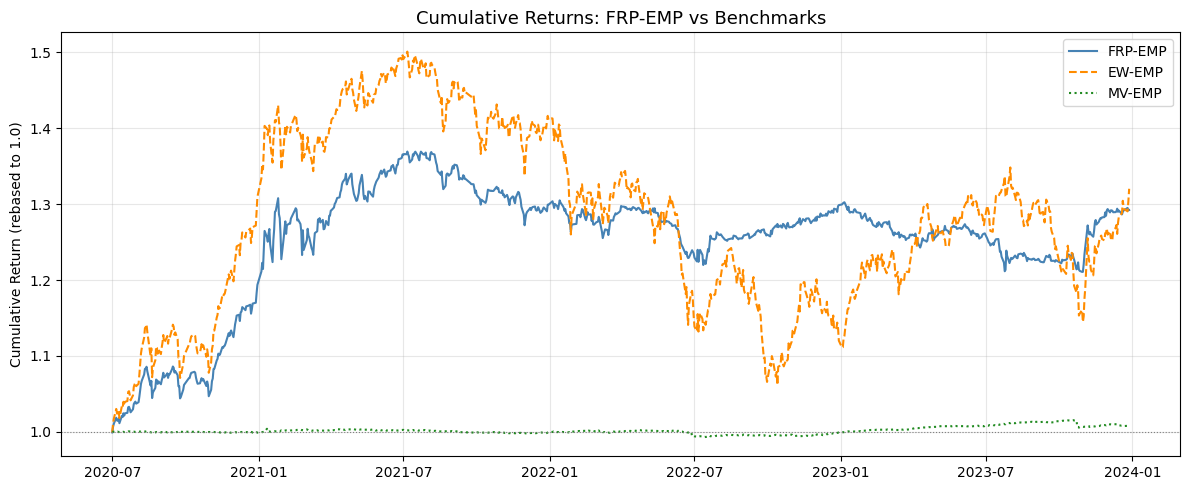

In [33]:
# ── 10a. Cumulative return comparison ─────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 5))

common_idx = ret_frp.index.intersection(ret_ew.index).intersection(ret_mv.index)
for ret, label, color, ls in [
    (ret_frp, "FRP-EMP", "steelblue",  "-"),
    (ret_ew,  "EW-EMP",  "darkorange", "--"),
    (ret_mv,  "MV-EMP",  "forestgreen",":" ),
]:
    cum = (1.0 + ret.loc[common_idx]).cumprod()
    ax.plot(cum, label=label, color=color, linestyle=ls, linewidth=1.5)

ax.axhline(1.0, color="gray", linewidth=0.8, linestyle=":")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.set_title("Cumulative Returns: FRP-EMP vs Benchmarks", fontsize=13)
ax.set_ylabel("Cumulative Return (rebased to 1.0)")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
fig.savefig("../outputs/assets/am_frp_cumulative_returns.png", dpi=150, bbox_inches="tight")
plt.show()

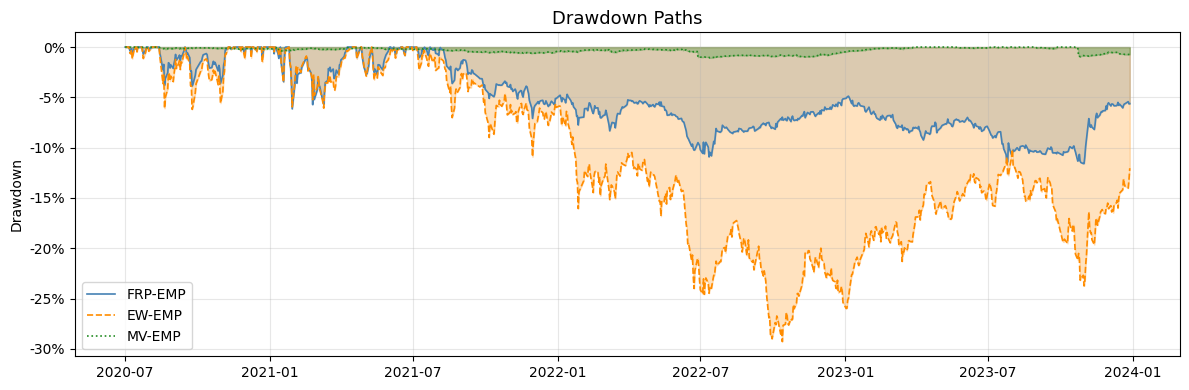

In [34]:
# ── 10b. Drawdown comparison ──────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 4))

for ret, label, color, ls in [
    (ret_frp, "FRP-EMP", "steelblue",  "-"),
    (ret_ew,  "EW-EMP",  "darkorange", "--"),
    (ret_mv,  "MV-EMP",  "forestgreen",":" ),
]:
    cum = (1.0 + ret.loc[common_idx]).cumprod()
    dd  = cum / cum.cummax() - 1.0
    ax.fill_between(dd.index, dd, 0, alpha=0.25, color=color)
    ax.plot(dd, label=label, color=color, linestyle=ls, linewidth=1.2)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.set_title("Drawdown Paths", fontsize=13)
ax.set_ylabel("Drawdown")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0%}"))
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
fig.savefig("../outputs/assets/am_frp_drawdowns.png", dpi=150, bbox_inches="tight")
plt.show()

<>:12: SyntaxWarning: invalid escape sequence '\p'
<>:12: SyntaxWarning: invalid escape sequence '\p'
C:\Users\chlje\AppData\Local\Temp\ipykernel_230532\2534718895.py:12: SyntaxWarning: invalid escape sequence '\p'
  ax.set_title("Stage 1 — Factor Allocation $\phi^*$ Over Time", fontsize=13)


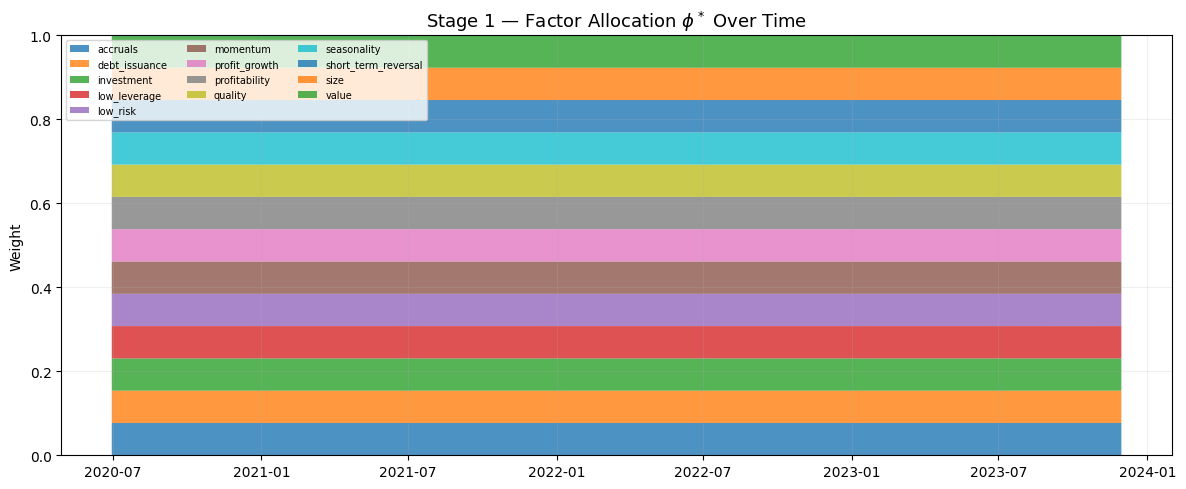

In [35]:
# ── 10c. phi_star evolution — factor allocation over time ─────────────────────
fig, ax = plt.subplots(figsize=(12, 5))

phi_plot = phi_star_ts.dropna(how="all").astype(float)
ax.stackplot(
    phi_plot.index,
    phi_plot.T.values,
    labels=factor_names,
    alpha=0.8,
)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.set_title("Stage 1 — Factor Allocation $\phi^*$ Over Time", fontsize=13)
ax.set_ylabel("Weight")
ax.set_ylim(0, 1)
ax.legend(loc="upper left", fontsize=7, ncol=3)
ax.grid(alpha=0.2)
plt.tight_layout()
fig.savefig("../outputs/assets/am_frp_factor_allocation.png", dpi=150, bbox_inches="tight")
plt.show()

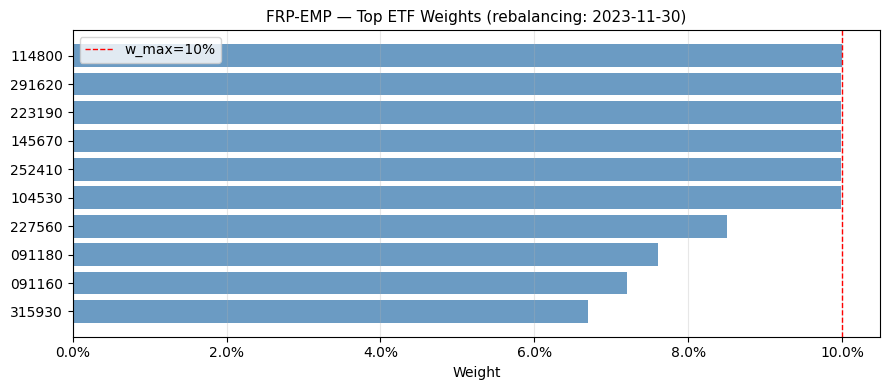

In [36]:
# ── 10d. Top-10 ETF weight contribution (FRP-EMP, latest rebalancing) ─────────
last_w = weights_frp.dropna(how="all").iloc[-1].sort_values(ascending=False)
top10  = last_w[last_w > 1e-4].head(10)

fig, ax = plt.subplots(figsize=(9, 4))
ax.barh(top10.index[::-1], top10.values[::-1], color="steelblue", alpha=0.8)
ax.axvline(W_MAX, color="red", linestyle="--", linewidth=1, label=f"w_max={W_MAX:.0%}")
ax.set_xlabel("Weight")
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1%}"))
ax.set_title(f"FRP-EMP — Top ETF Weights (rebalancing: {weights_frp.dropna(how='all').index[-1].date()})",
             fontsize=11)
ax.legend()
ax.grid(axis="x", alpha=0.3)
plt.tight_layout()
fig.savefig("../outputs/assets/am_frp_top_etf_weights.png", dpi=150, bbox_inches="tight")
plt.show()

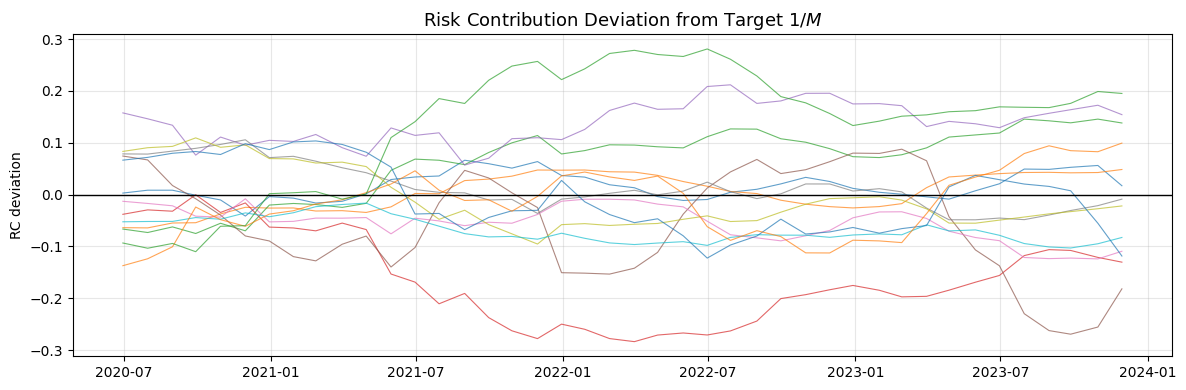

In [37]:
# ── 10e. Rolling risk contributions (ERC deviation from 1/M target) ────────────
fig, ax = plt.subplots(figsize=(12, 4))

rc_plot   = rc_ts.dropna(how="all").astype(float)
target_rc = 1.0 / M
deviation = rc_plot - target_rc

for col in deviation.columns:
    ax.plot(deviation.index, deviation[col], linewidth=0.8, alpha=0.7)

ax.axhline(0, color="black", linewidth=1.0)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.set_title("Risk Contribution Deviation from Target $1/M$", fontsize=13)
ax.set_ylabel("RC deviation")
ax.grid(alpha=0.3)
plt.tight_layout()
fig.savefig("../outputs/assets/am_frp_rc_deviation.png", dpi=150, bbox_inches="tight")
plt.show()

C:\Users\chlje\AppData\Local\Temp\ipykernel_230532\3849599030.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


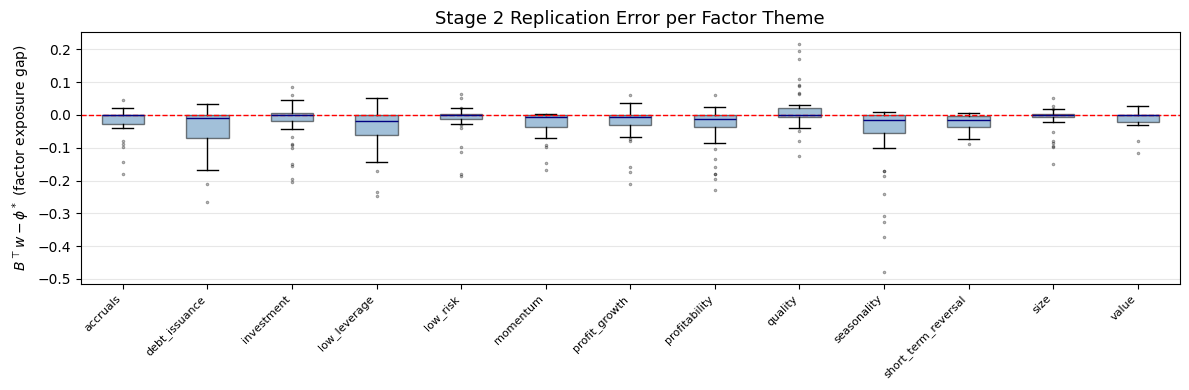

In [38]:
# ── 10f. Replication error — factor exposure gap ──────────────────────────────
fig, ax = plt.subplots(figsize=(12, 4))

err_plot = repl_error.dropna(how="all").astype(float)
ax.boxplot(
    [err_plot[col].dropna().values for col in err_plot.columns],
    labels=factor_names,
    vert=True,
    patch_artist=True,
    boxprops=dict(facecolor="steelblue", alpha=0.5),
    medianprops=dict(color="navy"),
    flierprops=dict(marker=".", markersize=3, alpha=0.4),
)
ax.axhline(0, color="red", linewidth=1, linestyle="--")
ax.set_xticklabels(factor_names, rotation=45, ha="right", fontsize=8)
ax.set_title("Stage 2 Replication Error per Factor Theme", fontsize=13)
ax.set_ylabel("$B^\\top w - \\phi^*$ (factor exposure gap)")
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
fig.savefig("../outputs/assets/am_frp_replication_error.png", dpi=150, bbox_inches="tight")
plt.show()

---

## 11. Summary

In [39]:
print("=" * 72)
print("TWO-STAGE FRP-EMP — PERFORMANCE SUMMARY")
print("=" * 72)
print(perf.to_string())
print("=" * 72)
print(f"\nAnalysis window : {dates[0].date()} → {dates[-1].date()}")
print(f"ETF universe    : N={N}")
print(f"Factor space    : M={M} JKP themes")
print(f"Roll window     : {WINDOW} trading days")
print(f"Rebalancing     : monthly (Business Month End), {len(reb_dates)} events")
print(f"Max ETF weight  : {W_MAX:.0%}")
print("\nKey design choices:")
print("  Stage 1 solver : scipy.optimize.minimize (SLSQP) — log-barrier FRP")
print("  Stage 2 solver : CVXPY / CLARABEL — constrained QP")
print("  Beta source    : rolling OLS on [mkt + 13 JKP themes]; Stage 2 uses 13 JKP only")

TWO-STAGE FRP-EMP — PERFORMANCE SUMMARY
         Ann.Ret Ann.Vol Sharpe    MaxDD Calmar Turnover     HHI
Strategy                                                        
FRP-EMP   +7.77%   8.16%  0.952  -11.58%  0.671   0.7526  0.0574
EW-EMP    +8.44%  14.96%  0.564  -29.27%  0.288   0.0128  0.0073
MV-EMP    +0.23%   0.90%  0.259   -1.08%  0.217   0.4086  0.0580

Analysis window : 2020-01-03 → 2023-12-28
ETF universe    : N=194
Factor space    : M=13 JKP themes
Roll window     : 120 trading days
Rebalancing     : monthly (Business Month End), 42 events
Max ETF weight  : 10%

Key design choices:
  Stage 1 solver : scipy.optimize.minimize (SLSQP) — log-barrier FRP
  Stage 2 solver : CVXPY / CLARABEL — constrained QP
  Beta source    : rolling OLS on [mkt + 13 JKP themes]; Stage 2 uses 13 JKP only
